In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import random

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from wandb.keras import WandbCallback

In [3]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [61]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [62]:
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [63]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [64]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

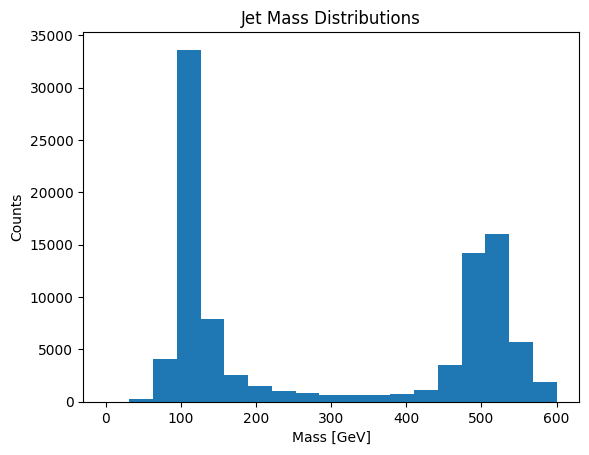

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [10]:
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq.txt")

jets = []
count = 0
for line in file:
    if count == 2:
        break
    print(line)
    jets += [line.split("J")[1].split("P")[0].split()]
    count+=1

0 0 J 1788.55 -0.300279 -2.51608 130.279 0 0.0289343 0.0153102 0.0126833 0.010346 0.00825964  P 4.64413 -0.377384 3.00207  P 2.47947 -0.425799 3.02334  P 2.68613 -0.39458 -2.608  P 5.84707 -0.404504 -2.54133  P 24.9416 -0.408844 -2.52053  P 6.58412 -0.387347 -2.54543  P 13.1517 -0.350432 -2.59254  P 13.7381 -0.300859 -2.52212  P 4.55674 -0.286343 -2.52545  P 517.142 -0.286492 -2.50205 

0 1 J 1643.32 -0.173344 0.717105 95.8961 0 0.0424313 0.0221081 0.0140335 0.0108518 0.00877299  P 1.75001 -0.530883 0.585762  P 2.74298 -0.297844 0.694373  P 5.4756 -0.195946 0.630677  P 7.35714 -0.200437 0.647468  P 9.16487 -0.119969 0.704896  P 5.77878 -0.125155 0.709119  P 6.37682 -0.141306 0.773328  P 8.23397 -0.155549 0.732862  P 29.6409 -0.186092 0.763671  P 2.24246 -0.170876 0.729569  P 245.519 -0.180535 0.735561 



In [56]:
jets

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964'],
 ['1643.32',
  '-0.173344',
  '0.717105',
  '95.8961',
  '0',
  '0.0424313',
  '0.0221081',
  '0.0140335',
  '0.0108518',
  '0.00877299']]

In [31]:
ljet = [jets[2*n] for n in range(int(len(jets)/2))]
sjet = [jets[2*n+1] for n in range(int(len(jets)/2))]

In [32]:
ljet

[['1788.55',
  '-0.300279',
  '-2.51608',
  '130.279',
  '0',
  '0.0289343',
  '0.0153102',
  '0.0126833',
  '0.010346',
  '0.00825964']]

In [11]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [12]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [13]:
m = 100
file = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(m)+"_"+str(m)+".txt")
jets_m_m = []
for line in file:
    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
    pass
computemjj_txt(jets_m_m)[0]

3674.182176987098

In [44]:
len(jets_m_m)

180286

In [5]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array", x_array)

In [6]:
#reads in data 
x = {}
x_array_read = np.load("x_array.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [56]:
#initializies wandb config
if not wandb.run:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Anomaly",
        group="Dedicated",
        entity='gup-singh',
        mode = 'disabled',

        config={
            "layer_1": 256,
            "activation_1": "relu",
            "layer_2": 256,
            "activation_2": "relu",
            "layer_3": 256,
            "activation_3": "relu",
            "output_layer": 1,
            "output_activation": "sigmoid",
            "optimizer": "adam",
            "loss": "binary_crossentropy",
            "metric": "accuracy",
            "epoch": 20,
            "batch_size": 1024
        }
    )

config = wandb.config

In [57]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        
        self.dense2 = Dense(config.layer_2, activation=config.activation_2)
        
        self.dense3 = Dense(config.layer_3, activation=config.activation_3)
        
        self.dense4 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        
        x = self.dense2(x)
        
        x = self.dense3(x)
        
        x = self.dense4(x)
        
        return x

In [58]:
x_vals_100 = np.concatenate([x[0,0],x[1,1]])
y_vals_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_vals_100, y_vals_100, test_size=0.5)

model = MyModel()
model.build(input_shape=(None, X_train_100.shape[1]))
model.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model.summary()

Model: "my_model_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_584 (Dense)           multiple                  1280      
                                                                 
 dense_585 (Dense)           multiple                  65792     
                                                                 
 dense_586 (Dense)           multiple                  65792     
                                                                 
 dense_587 (Dense)           multiple                  257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


In [59]:
myhistory = model.fit(x_vals_100, y_vals_100, epochs=config.epoch, validation_data=(X_val_100, Y_val_100),batch_size=config.batch_size, callbacks=[WandbCallback()])

Epoch 1/20
193/193 [==============================] - 1s 3ms/step - loss: 0.2469 - accuracy: 0.8989 - val_loss: 0.1865 - val_accuracy: 0.9251
Epoch 2/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9274 - val_loss: 0.1790 - val_accuracy: 0.9284
Epoch 3/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9278 - val_loss: 0.1772 - val_accuracy: 0.9283
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9288 - val_loss: 0.1800 - val_accuracy: 0.9272
Epoch 5/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1784 - accuracy: 0.9282 - val_loss: 0.1775 - val_accuracy: 0.9281
Epoch 6/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9288 - val_loss: 0.1754 - val_accuracy: 0.9289
Epoch 7/20
193/193 [==============================] - 0s 2ms/step - loss: 0.1766 - accuracy: 0.9288 - val_loss: 0.1788 - val_accuracy: 0.9278
Epoch 

In [21]:
wandb.finish()

In [25]:
preds_mm_list = []
fpr_mm_list = []
tpr_mm_list = []

for i in mass_range[1:]:
    for j in mass_range[1:]:
        x_vals_mm = np.concatenate([x[0,0],x[i,j]])
        y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
        X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)
        
        modelmm = MyModel()
        modelmm.build(input_shape=(None, X_train_mm.shape[1]))
        modelmm.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
        myhistory_mm = model.fit(x_vals_mm, y_vals_mm, epochs=config.epoch, validation_data=(X_val_mm, Y_val_mm),batch_size=config.batch_size, callbacks=[WandbCallback()])
        
        preds_mm = model.predict(X_val_mm,batch_size=1000)
        fpr_mm, tpr_mm, _ = roc_curve(Y_val_mm, preds_mm)
        
        preds_mm_list.append(preds_mm)
        fpr_mm_list.append(fpr_mm)
        tpr_mm_list.append(tpr_mm)

Epoch 1/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2793 - accuracy: 0.8833 - val_loss: 0.2594 - val_accuracy: 0.8906
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2555 - accuracy: 0.8924 - val_loss: 0.2528 - val_accuracy: 0.8928
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2529 - accuracy: 0.8938 - val_loss: 0.2520 - val_accuracy: 0.8933
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2527 - accuracy: 0.8941 - val_loss: 0.2508 - val_accuracy: 0.8942
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.8944 - val_loss: 0.2519 - val_accuracy: 0.8937
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.8943 - val_loss: 0.2514 - val_accuracy: 0.8943
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2510 - accuracy: 0.8948 - val_loss: 0.2501 - val_accuracy: 0.8950
Epoch 

In [46]:
len(tpr_mm_list)

144

/tmp/ipykernel_1886067/1560960496.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
/tmp/ipykernel_1886067/1560960496.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_{B},m_{C})$ 50 $\\Rightarrow$ 600 GeV Dedicated vs Parametrized')

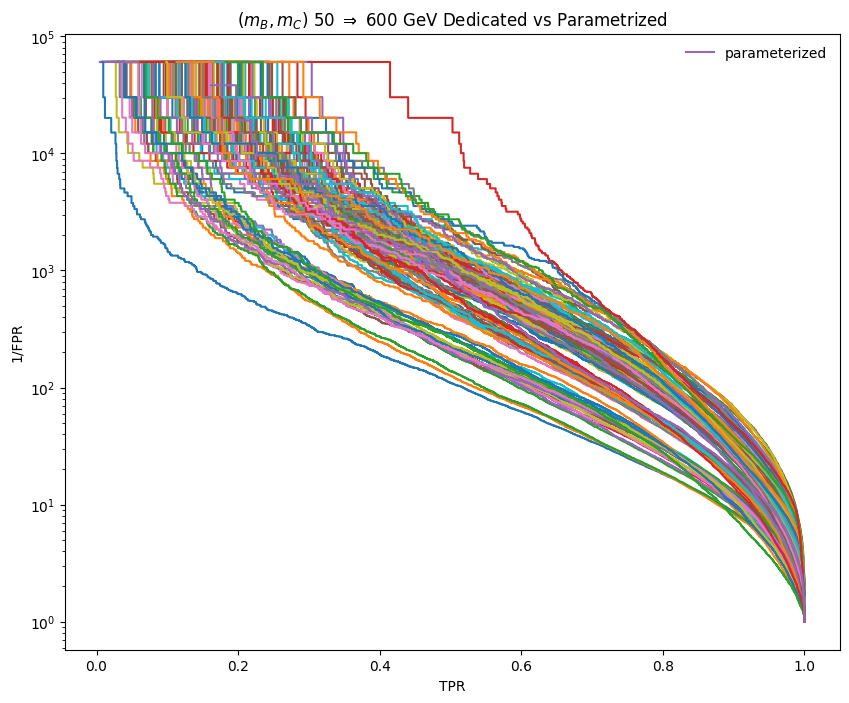

In [91]:
plt.figure(figsize=(10,8))
for i in range(len(tpr_mm_list)):
    plt.plot(tpr_mm_list[i], 1./fpr_mm_list[i])
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_{B},m_{C})$ 50 $\Rightarrow$ 600 GeV Dedicated vs Parametrized")

Analysis of Models begins here

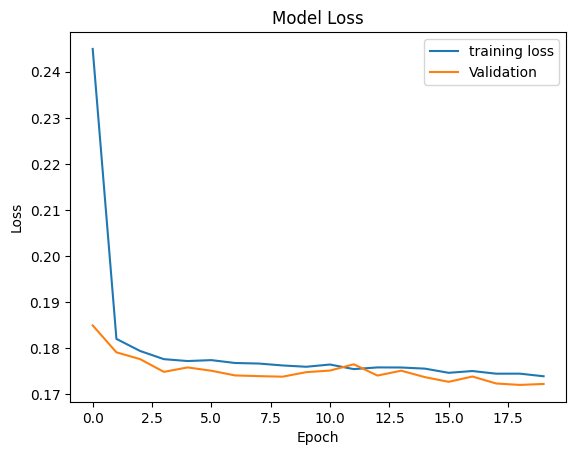

In [255]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [78]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 637us/step


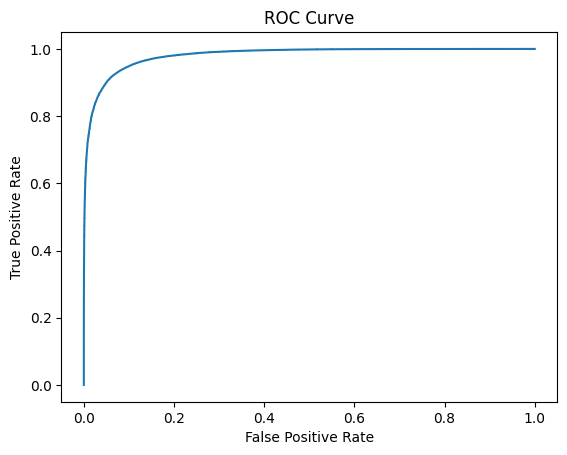

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [258]:
def pred_accuracy(y_test, predictions):

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_model = pred_accuracy(Y_val_100, list(preds_100))
print("Accuracy of Model: {:.2%}".format(accuracy_model))

Accuracy of Model: 93.07%


In [33]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.ones(len(x_aug_0)),np.zeros(len(x_aug_m))])

    np.save("x_vals_all",x_vals_all)
    np.save("y_vals_all",y_vals_all)

In [97]:
x_aug_m

array([[-0.72413866,  1.69355063,  1.11205286, -1.87386705,  6.        ,
         6.        ],
       [ 0.80799657,  0.66064736, -0.59943671, -2.09319001,  6.        ,
         6.        ],
       [ 2.17499885, -1.1884174 , -1.60538663, -1.95211824,  6.        ,
         6.        ],
       ...,
       [ 2.25225265, -1.04538567, -1.74062478, -0.42062581,  6.        ,
         6.        ],
       [ 1.9191695 , -0.87384445, -1.59395235, -2.25172332,  6.        ,
         6.        ],
       [ 0.04826932,  1.34560735, -0.34342313, -1.79483175,  6.        ,
         6.        ]])

In [64]:
x_vals_all = np.load("x_vals_all.npy")
y_vals_all = np.load("y_vals_all.npy")

In [65]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [66]:
len(X_train_all)

13594326

In [67]:
if not wandb.run:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Anomaly",
        group="Parametrized",
        entity='gup-singh',
        mode = 'disabled',

        config={
            "layer_1": 256,
            "activation_1": "relu",
            "layer_2": 256,
            "activation_2": "relu",
            "layer_3": 256,
            "activation_3": "relu",
            "output_layer": 1,
            "output_activation": "sigmoid",
            "optimizer": "adam",
            "loss": "binary_crossentropy",
            "metric": "accuracy",
            "epoch": 20,
            "batch_size": 1024
        }
    )

config = wandb.config

In [68]:
model_all = MyModel()
model_all.build(input_shape=(None, X_train_all.shape[1]))
model_all.compile(loss=config.loss, optimizer=config.optimizer, metrics=["accuracy"])
model_all.summary()

Model: "my_model_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_588 (Dense)           multiple                  1792      
                                                                 
 dense_589 (Dense)           multiple                  65792     
                                                                 
 dense_590 (Dense)           multiple                  65792     
                                                                 
 dense_591 (Dense)           multiple                  257       
                                                                 
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________


In [69]:
myhistory_all = model_all.fit(x_vals_all, y_vals_all, epochs=config.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config.batch_size*5, callbacks = [WandbCallback()])

Epoch 1/20
5311/5311 [==============================] - 12s 2ms/step - loss: 0.1714 - accuracy: 0.9327 - val_loss: 0.1630 - val_accuracy: 0.9359
Epoch 2/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1623 - accuracy: 0.9363 - val_loss: 0.1629 - val_accuracy: 0.9360
Epoch 3/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1617 - accuracy: 0.9366 - val_loss: 0.1618 - val_accuracy: 0.9365
Epoch 4/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1613 - accuracy: 0.9367 - val_loss: 0.1613 - val_accuracy: 0.9367
Epoch 5/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1611 - accuracy: 0.9368 - val_loss: 0.1610 - val_accuracy: 0.9369
Epoch 6/20
5311/5311 [==============================] - 10s 2ms/step - loss: 0.1608 - accuracy: 0.9369 - val_loss: 0.1611 - val_accuracy: 0.9367
Epoch 7/20
5311/5311 [==============================] - 11s 2ms/step - loss: 0.1607 - accuracy: 0.9369 - val_loss: 0.1607 - val_ac

In [70]:
wandb.finish()

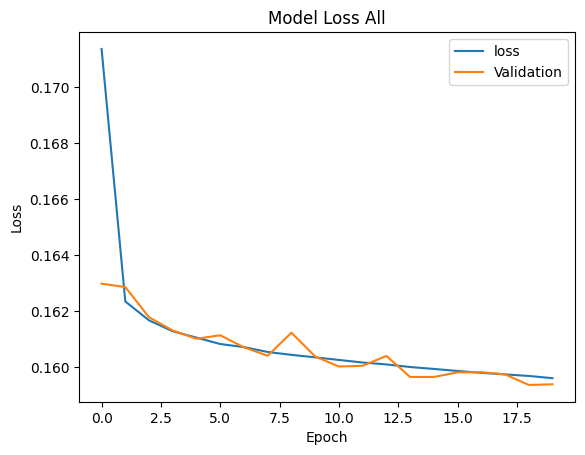

In [71]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [72]:
preds_all = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1],batch_size=1000)

99/99 [==============================] - 0s 659us/step


In [73]:
fpr_all, tpr_all, _ = roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1.,1.],axis=1)==1], preds_all)

/tmp/ipykernel_1886067/2571013946.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
/tmp/ipykernel_1886067/2571013946.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all,1./fpr_all,label="parameterized")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized')

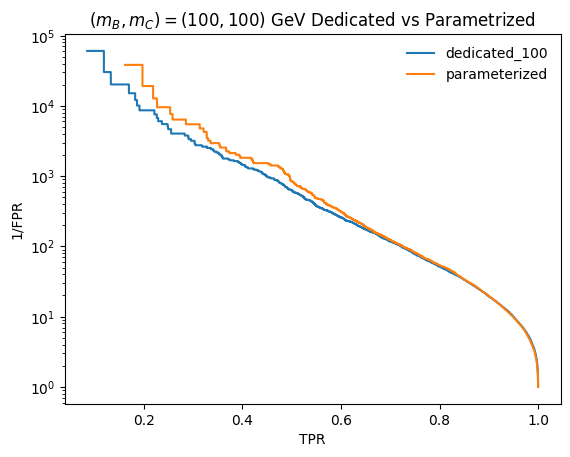

In [80]:
plt.plot(tpr_100,1./fpr_100,label="dedicated_100")
plt.plot(tpr_all,1./fpr_all,label="parameterized")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated vs Parametrized")

In [81]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

#creates models with single node and arbitrary weight
def createSimpleModel(weight):
    input_layer = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(weight))(input_layer)
    model = Model(inputs=input_layer, outputs=simple_model)
    return model

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [82]:
model_all2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.ones_like_1 (TFOpLambda)    (None, 4)            0           ['input_3[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None,)             0           ['tf.ones_like[0][0]']           
 ingOpLambda)                                                                               

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [31]:
class SingleWeightLayer(tf.keras.layers.Layer):
    def __init__(self, initial_value=1, **kwargs):
        super(SingleWeightLayer, self).__init__(**kwargs)
        self.initial_value = initial_value
        
    def build(self, input_shape):
        self.weight = self.add_weight(shape=(1,), initializer=tf.keras.initializers.Constant(self.initial_value), trainable=True)
    
    def call(self, inputs):            
        output = inputs * self.weight
        return tf.nn.relu(output)

In [84]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(2.)
            model32 = createSimpleModel(3.)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.ones(len(x[0,0])),np.zeros(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(x_vals_[:,0:4], y_vals_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

Epoch 1/10
192/192 [==============================] - 1s 3ms/step - loss: 1.7732 - val_loss: 0.7816
Epoch 2/10
192/192 [==============================] - 0s 2ms/step - loss: 0.7367 - val_loss: 0.6988
Epoch 3/10
192/192 [==============================] - 0s 2ms/step - loss: 0.6716 - val_loss: 0.6444
Epoch 4/10
192/192 [==============================] - 0s 2ms/step - loss: 0.6251 - val_loss: 0.6062
Epoch 5/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5964 - val_loss: 0.5873
Epoch 6/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5842 - val_loss: 0.5803
Epoch 7/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5798 - val_loss: 0.5780
Epoch 8/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5786 - val_loss: 0.5775
Epoch 9/10
192/192 [==============================] - 0s 2ms/step - loss: 0.5784 - val_loss: 0.5774
Epoch 10/10
192/192 [==============================] - 1s 3ms/step - loss: 0.5784 - val_loss: 0.5774

In [85]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass
    
print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.5147933 8.642921 ]
[0.5 1. ] [0.9863735 8.952675 ]
[0.5 1.5] [1.4846948 9.277658 ]
[0.5 2. ] [2.0011148 9.517386 ]
[0.5 2.5] [2.4338436 2.6302505]
[0.5 3. ] [2.9218297 3.1563454]
[0.5 3.5] [3.4139726 3.6900306]
[0.5 4. ] [3.9214833 4.175332 ]
[0.5 4.5] [4.3534274 4.6330385]
[0.5 5. ] [4.816453  5.0911903]
[0.5 5.5] [5.258252  5.5252404]
[0.5 6. ] [5.7188363 5.9910483]
[1.  0.5] [1.001016 8.957571]
[1. 1.] [0.9951113 8.677592 ]
[1.  1.5] [ 1.0449007 10.1748295]
[1. 2.] [1.9782991 8.534287 ]
[1.  2.5] [2.3967693 2.6159456]
[1.5 0.5] [1.4930831 9.294746 ]
[1.5 1. ] [ 1.0348134 10.162425 ]
[2.  0.5] [1.994548 9.525516]
[2. 1.] [1.9720806 8.526257 ]
[2.5 0.5] [2.4480386 2.6651366]
[2.5 1. ] [2.4028018 2.6252759]
[3.  0.5] [2.946037  3.1613739]
[3.5 0.5] [3.425302  3.6775723]
[4.  0.5] [3.9210944 4.175582 ]
[4.5 0.5] [4.377937 4.631792]
[5.  0.5] [4.838618 5.072845]
[5.5 0.5] [5.3222394 5.532457 ]
[6.  0.5] [5.7440186 5.9966784]
found both: 0.7916666666666666
found one: 0.208333

In [326]:
sig_list = []
weight_list1 = []
weight_list2 = []
weight_list3 = []

msic1 = []
msic2 = []

fpr1_list = []
tpr1_list = []

fpr2_list = []
tpr2_list = []

epsilon = tf.constant(1e-6)

for sigfrac in np.logspace(-2, 2,20):
    #sigfrac = 0.1
    print(sigfrac)
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    model3 = createSimpleModel(2)
    model32 = createSimpleModel(3)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1. - hidden_layer_1 + epsilon)
    #LLR_xs = 1.+sigfrac*LLR
    mu = model33(tf.ones_like(inputs)[:,0])
    #mu = 0.1
    LLR_xs = 1. + mu*LLR - mu
    ws = (LLR_xs)/ (1.+ LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    #create ws data set
    m1 = 2
    m2 = 4.5

    #background
    test_background = int(1/2 *len(x[0,0]))
    train_background = int(1/4 * len(x[0,0]))
    train_reference = int(1/4 * len(x[0,0]))
    #signal
    test_signal_length = int(1/2*len(x[m1,m2]))
    N = int(1/4 * (len(x[0,0])))
    #signal = x[m1, m2][test_signal_length:test_signal_length + int(.1*len(x[m1, m2]))]
    signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*test_background)]

    #[reference (1), data_background (1), signal(0)]
    x_vals_ = np.concatenate([x[0,0][test_background:], signal])
    y_vals_ = np.concatenate([np.ones(train_reference), np.ones(train_background + 1), np.zeros(len(signal))])

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)

    trainble_weight1 = model_all2.trainable_weights[0].numpy()[0][0]
    trainble_weight2 = model_all2.trainable_weights[1].numpy()[0][0]
    trainble_weight3 = model_all2.trainable_weights[2].numpy()[0][0]

    print(m1,m2,trainble_weight1,trainble_weight2)

    sig_list+=[sigfrac]
    weight_list1+=[trainble_weight1]
    weight_list2+=[trainble_weight2]
    weight_list3+=[trainble_weight3]
    
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr, tpr, thresholds = roc_curve(y, scores)
    
    fpr1_list.append(fpr)
    tpr1_list.append(tpr)
    msic1+=[np.max(tpr/np.sqrt(fpr+epsilon))]
    
    #comparison case
    model_cwola = Sequential()
    model_cwola.add(Dense(256, input_dim=4, activation='relu'))
    model_cwola.add(Dense(256, activation='relu'))
    model_cwola.add(Dense(256, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
    fpr2, tpr2, _ = roc_curve(y2, scores2)
    
    fpr2_list.append(fpr2)
    tpr2_list.append(tpr2)
    msic2+=[np.max(tpr2/np.sqrt(fpr2+epsilon))]

0.01
Epoch 1/20
30/30 [==============================] - 1s 8ms/step - loss: 0.1026 - val_loss: 0.0976
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0915 - val_loss: 0.0878
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0862 - val_loss: 0.0871
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0846 - val_loss: 0.0868
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 8/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.0843 - val_loss: 0.0867
Epoch 11/20
30

In [293]:
sig_list

[0.01,
 0.016237767391887217,
 0.026366508987303583,
 0.04281332398719394,
 0.06951927961775606,
 0.11288378916846889,
 0.18329807108324356,
 0.29763514416313175,
 0.4832930238571752]

(0.0, 700.0)

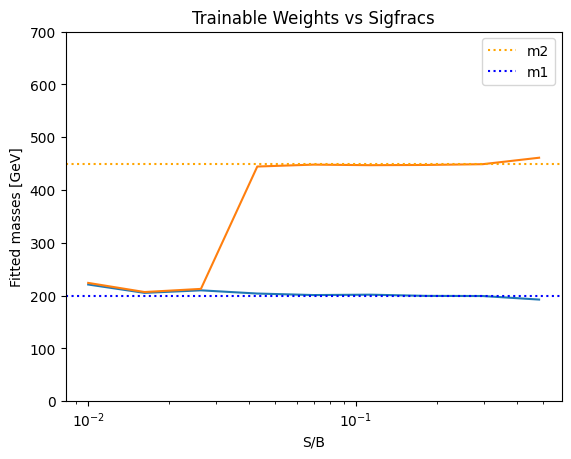

In [294]:
plt.plot(sig_list,np.array(weight_list1)*100)
plt.plot(sig_list,np.array(weight_list2)*100)
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.axhline(m2*100,ls=":",color='orange', label = "m2")
plt.axhline(m1*100,ls=":",color='blue', label = "m1")
plt.legend()
plt.title("Trainable Weights vs Sigfracs")
plt.ylim([0,700])

95/95 [==============================] - 0s 781us/step


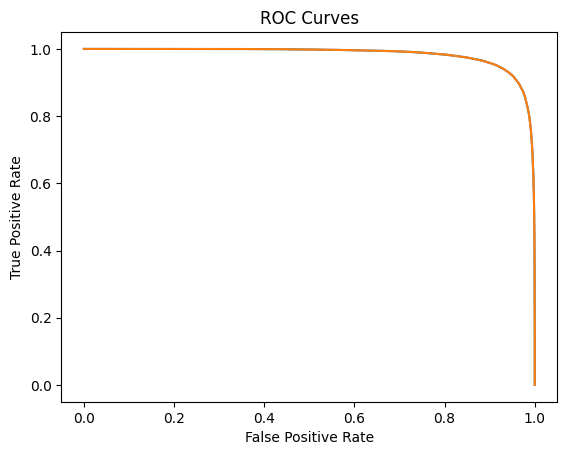

In [332]:
scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
fpr, tpr, thresholds = roc_curve(y, scores)
plt.plot(fpr, 1-tpr)
scores2 = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal_length]]),batch_size=1024)
y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal_length)])
fpr2, tpr2, thresholds2 = roc_curve(y2, scores2)
plt.plot(fpr2, 1-tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


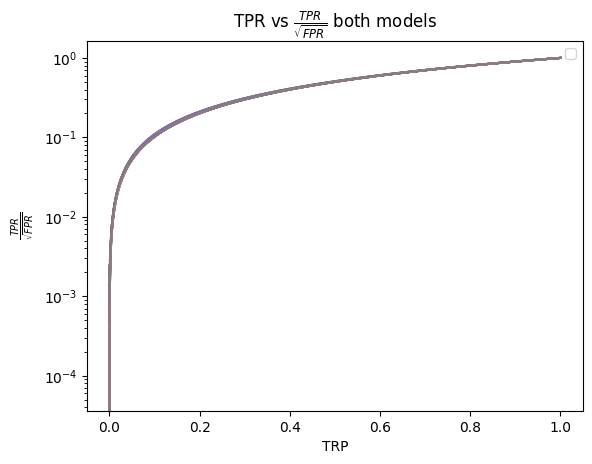

In [328]:
for i in range(len(tpr1_list)):
    plt.plot(tpr1_list[i],tpr1_list[i]/np.sqrt(fpr1_list[i] + epsilon))
    plt.plot(tpr2_list[i],tpr2_list[i]/np.sqrt(fpr2_list[i] + epsilon))
plt.xlabel("TRP")
plt.ylabel("$\\frac{TPR}{\\sqrt{FPR}}$")
plt.yscale("log")
plt.title("TPR vs $\\frac{TPR}{\\sqrt{FPR}}$ both models")
plt.legend()
plt.show()

Text(0, 0.5, 'Fitted S/B')

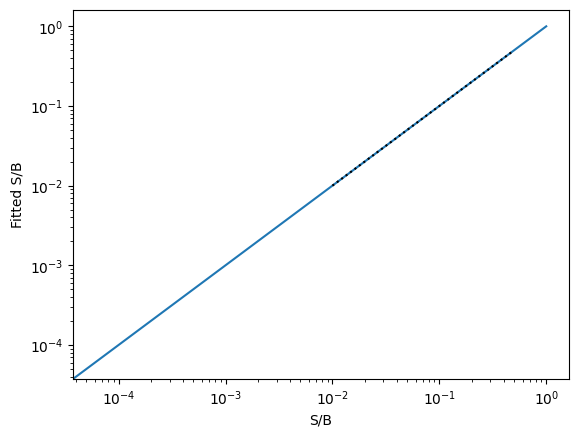

In [346]:
#same x and y for now
plt.plot(tpr1_list[0]/np.sqrt(fpr1_list[0] + epsilon),tpr1_list[0]/np.sqrt(fpr1_list[0] + epsilon))
plt.xscale("log")
plt.yscale("log")
plt.plot(sig_list,sig_list,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

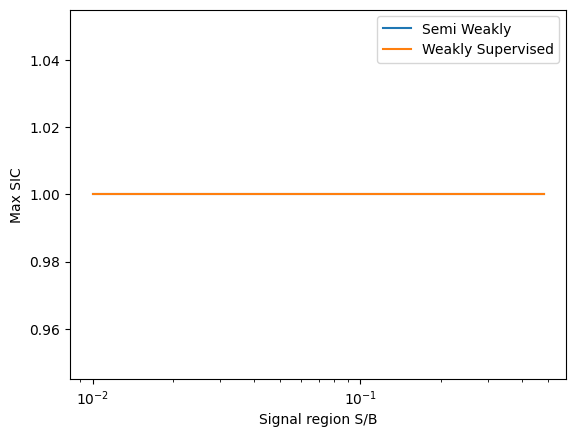

In [352]:
plt.plot(sig_list,msic1,label="Semi Weakly")
plt.plot(sig_list,msic2,label="Weakly Supervised")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")
plt.show()